## Experiment 1 

- [ ] All in the MVP plus...
- [ ] use the mean of 40 mfcc channel as input for the SVM 




### Interesting notes

https://musicinformationretrieval.com/


In [1]:
## Remove files that are corrupted in audio_test

import os
import os.path

for file in ['audio_test/0b0427e2.wav', 'audio_test/6ea0099f.wav', 'audio_test/b39975f5.wav']:
    if os.path.isfile(file):
        os.remove(file)


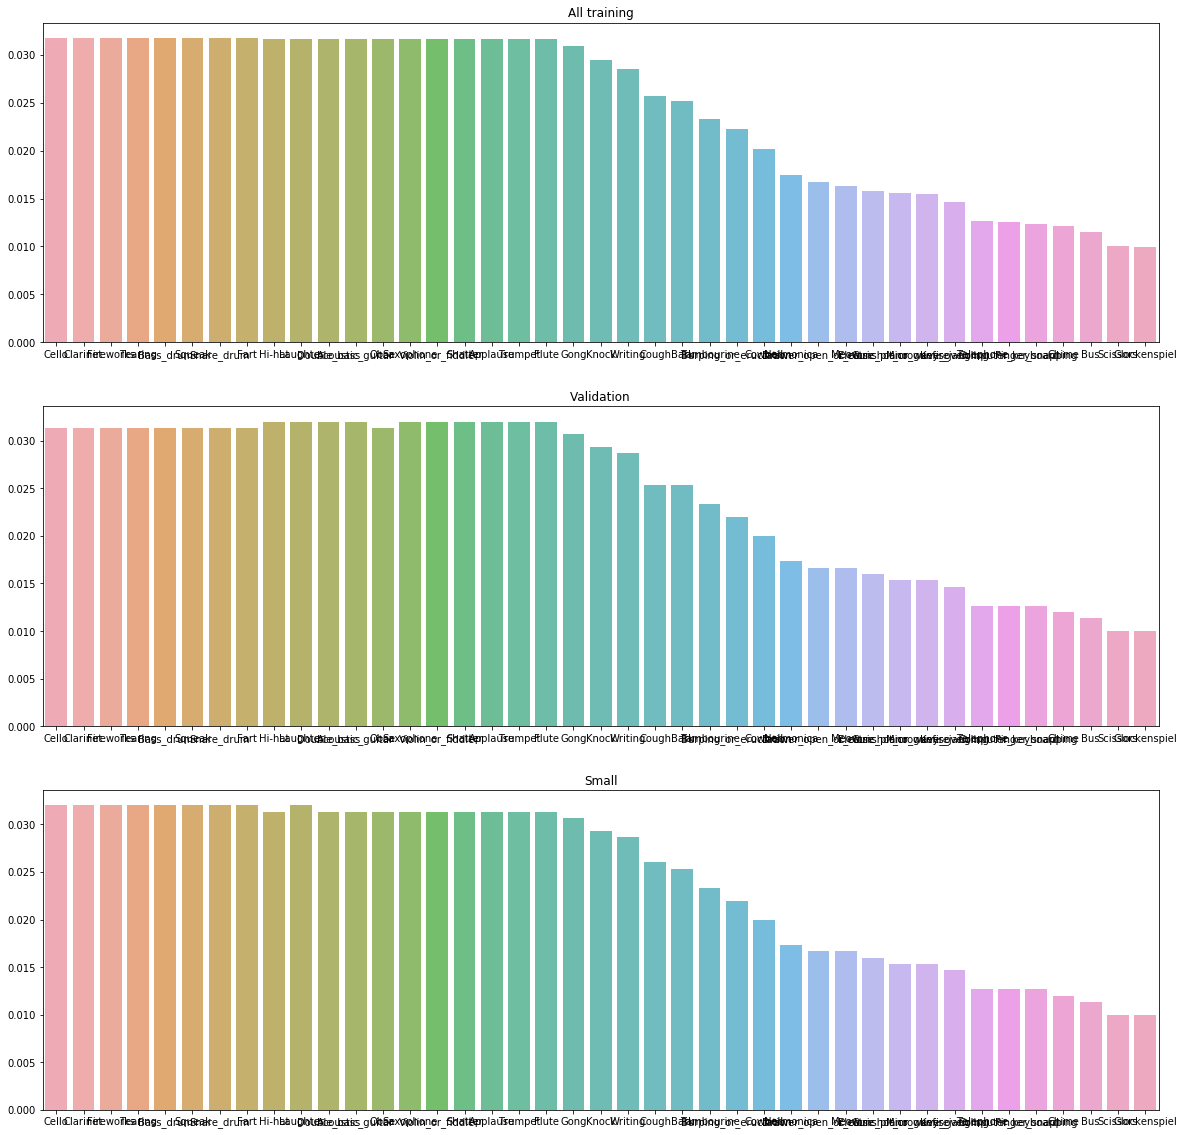

In [2]:
%matplotlib inline
EXPERIMENT_NAME = "svm/"

import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Read the CSV file
df = pd.read_csv('train.csv')
df['label'] = df['label'].astype('category')

## Create a BIG train dataset and a validation
train, validation = train_test_split(df, test_size=1500, random_state=1, stratify=df['label'])

## from the big train, we create a small one to make fastest computations
_, small = train_test_split(train, test_size=1500, random_state=1, stratify=train['label'])

def plot_categorical_variable_distribution(serie, ax, title="Distribution", order = None):
    count  = serie.value_counts(normalize=True)
    ax.set_title(title)
    sns.barplot(count.index, count.values, alpha=0.8, order=order, ax=ax)

## Print the repetition of each class, to be sure that the distribution is acceptable for validation and small sets
fig, axes = plt.subplots(3, 1, figsize=(20, 20))
order = train['label'].value_counts().index

plot_categorical_variable_distribution(train['label'], axes.flat[0], title= "All training", order=order)
plot_categorical_variable_distribution(validation['label'], axes.flat[1], title= "Validation", order=order)
plot_categorical_variable_distribution(small['label'], axes.flat[2], title = "Small", order=order)


## process audio

1. for each filename
   1. Load it
   2. Extract mean of zero-crossing rate
   3. Extract mean of zerospectral centrol
2. Convert the column of string of classification to a number 

At the end be have two variable x, y (from the training set)

In [3]:
## Load wavefiles and calculate some features
import librosa
import numpy as np


def get_features_for_file(filename):
    signal, sr = librosa.load(filename, res_type='kaiser_fast' )

    mfcc = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=40)
    return mfcc.mean(axis=-1)

filename = "audio_train/0526ac41.wav"

p = get_features_for_file(filename)
p.shape

(40,)

In [4]:
import os.path


## for each filename get the 
def get_features(x):
    x = map(get_features_for_file, x)
    x = np.array(list(x))

    return x


def process_csv(data, file):
    """
    Loads the wavfiles from each row
    Transforms them
    """
    
    x = data['fname']
    x = map(lambda f: "audio_train/" + f, x.values)
    y = np.array(data['label'].cat.codes)


    if not os.path.isfile(file): 
        x = get_features(x)
        np.save(file, x)
    else:
        x = np.load(file)    
    
    return x, y

x, y = process_csv(small, "%s/small_x.npy" % EXPERIMENT_NAME)
x_validation, y_validation = process_csv(validation, "%s/validation_x.npy" % EXPERIMENT_NAME)
x_full, y_full = process_csv(train, "%s/full_x.npy" % EXPERIMENT_NAME)



In [5]:
import glob
test_files = glob.glob("audio_test/*.wav")

def load_test(filename):
    if not os.path.isfile(filename):
        x = get_features(test_files)
        np.save(filename, x)
    else:
        x = np.load(filename)
    return x

x_test = load_test("%s/test.npy" % EXPERIMENT_NAME)

## Scale

We adjust the variables so they have 0 meaning and std of 1

all columns of the `x` variable now is scaled.

We store this information so we can apply the same scale params we "learned" to the validation/test dataset

In [6]:
## Scale to 0 mean and 1 std
from sklearn import preprocessing

## We get some scale transformation from the training data, and we store it into 
## the scaler so then we can apply it to the test data

scaler = preprocessing.StandardScaler()


## Classification

Use SVM to classify, we use the probability since we need the top-3 candidates for the submission


In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


svm = SVC(probability=True, kernel='rbf')

pipeline = Pipeline([('scaler', scaler), ('svc', svm)])


Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'svc__C': Cs, 'svc__gamma' : gammas}

from sklearn.grid_search import GridSearchCV
estimator = GridSearchCV(pipeline, param_grid)
estimator.fit(x_full, y_full)

/home/kozko/kaggle/freesound/venv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kozko/kaggle/freesound/venv/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'svc__gamma': [0.001, 0.01, 0.1, 1], 'svc__C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

## Score (accurracy)

- Train accuracy 
- Validation accurracy

In [8]:
from sklearn.metrics import accuracy_score

predict_y = estimator.predict(x_full)
train_accuracy = accuracy_score(y_full, predict_y)

print("Train accuracy %s" % train_accuracy)

Train accuracy 0.5800827793804089


In [9]:
predict_y = estimator.predict(x_validation)
accuracy = accuracy_score(y_validation, predict_y)

print("Validation accuracy %s" % accuracy)

Validation accuracy 0.2713333333333333


In [10]:
test_probabilities = estimator.predict_proba(x_test)
np.save('%s/proba' % EXPERIMENT_NAME, test_probabilities)

## On kaggle the function used is MapK@3

In [11]:
import ml_metrics as metrics

def predict(x):
    probs = estimator.predict_proba(x)
    indices = np.argsort(-probs)
    
    return indices


def get_top_predict(indices, k=3):
    return list(map(lambda row: [row[0], row[1], row[2]], indices))

def score(x, y):
    actual = y.tolist()
    actual = map(lambda x: [x], actual)
    
    indices = predict(x)
    
    y_hat = get_top_predict(indices, k=3)
    return metrics.mapk(actual, y_hat, 3)

train_score = score(x_full, y_full)
validation_score = score(x_validation, y_validation)

print("Train score: %s\nvalidation score %s" % (train_score, validation_score))

Train score: 0.6532881809440193
validation score 0.3578888888888889


## Prepare for submission!


In [12]:
indices = predict(x_test)
result = get_top_predict(indices)

from os.path import basename

categories = {i: x for (i,x) in enumerate(df['label'].cat.categories) }

label = ["%s %s %s" % (categories[result[0]], categories[result[1]], categories[result[2]]) for result in result]

submission = pd.DataFrame(
    {'fname': list(map(lambda x: basename(x), test_files)),
     'label': label
    })

missing_data = pd.DataFrame(
    {'fname': ['0b0427e2.wav', '6ea0099f.wav', 'b39975f5.wav'],
     'label': 3 * ['Laughter Hi-Hat Flute']
    })

submission = submission.append(missing_data, ignore_index=True)

csv_file = '%s/submission.csv' % EXPERIMENT_NAME
if os.path.isfile(csv_file):
    os.remove(csv_file)

submission.to_csv(csv_file, index=False)

submission.head()

,fname,label
0,89049760.wav,Double_bass Knock Cello
1,4d732292.wav,Double_bass Knock Cello
2,952acae5.wav,Writing Gong Squeak
3,2d21041f.wav,Cello Acoustic_guitar Fireworks
4,16348aa9.wav,Acoustic_guitar Snare_drum Fart


In [13]:
!kaggle competitions submit -c freesound-audio-tagging -f $csv_file -m "mean of 40 mfcc for file on SVM with randomized grid search"


Successfully submitted to Freesound General-Purpose Audio Tagging Challenge